TODO
-------------
* FINISH THE PAPER BEFORE LEAVING FOR TAIWAN.
* Send first draft to Peter, Mark, Kyle, Jim, and Lakshmi.
* Send first revision to Martha and Jordan.
* Report human inter-rater reliability (Kappa).
* Identify subset of filters that specialize in the window containing the nonce word.
* Get all sentences that the model got wrong.  Divide them into groups first by whether the sentence contains an error, then by the current word (i.e. the preposition we care about), then by the gold standard (i.e. the value of the original word target).  Sample one hundred sentences from each group and read them.  For each group, write a hypothesis for why the model failed to predict correctly, and describe an experiment to test the hypothesis. 

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
run load_model.py

In [95]:
import json
import itertools
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
import pandas as pd
from sklearn.metrics import confusion_matrix, fbeta_score
import sklearn
import skll

In [8]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(
            itertools.combinations(s, r) for r in range(len(s)+1))

In [9]:
model_dir_20m = 'models/preposition/convnet/4e0ae5dc683611e5950afcaa149e39ea'
target_data = json.load(open('data/prepositions-all-new-target-data.json'))

In [10]:
m20m = load_model(model_dir_20m, input_file='data/prepositions-all-new-test.h5')

[(999552, 5), (999552, 52)]
('args', {u'clipnorm': 0, u'shuffle': True, u'target_name': u'original_word_code', u'validation_file': u'data/prepositions-all-new-validate.h5', u'n_word_dims': 50, u'data_name': [u'XwindowNULL', u'X', u'original_word_code'], u'extra_train_file': [u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-01.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-02.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-03.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-04.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-05.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-06.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-07.h5', u'data/prepositions-all-new-train-60000000/prepositions-all-new-train-60000000-08.h5', u'data/prepositions-all-new-

Using gpu device 0: GeForce GTX TITAN Black


In [11]:
probs = m20m.model.predict_proba(m20m.data)

999552/999552 [==============================] - 593s   


In [12]:
preds = np.argmax(probs, axis=1)

In [37]:
evens = np.arange(0, len(preds), 2)
odds = evens + 1

Error judgments from annotators
=======

In [6]:
# print(m20m.sent_id[4])
# print(m20m.sent_id[5])
# print(min(m20m.sent_id))
# print(max(m20m.sent_id))
# print(annotator1['Correct Preposition'][0])
# print(target_data['original_word_code']['names'][preds[4]])
# print(target_data['original_word_code']['names'][m20m.target[4]])
# print(annotator1['Sentence'][0])

def merge_ground_truth_and_judgments(annotator_df, annotator_id, metadata, preds, probs, target_data):
    """
    Merge ground truth, human judgments, and model predictions into a single data frame.
    
    Because of how I sampled the sentences for the humans to annotate, the sentences
    in the annotator's data set with IDs < 30600000 are (presumably) error free, and
    those with IDs > 30600000 contain a preposition error.  For each sentence ID in
    the annotator's data set, I need to find the indices of the two positions in the
    test set used by the model, and select the first of the two indices (the one at
    an even-numbered index) if the sentence ID < 30600000 and use select the second
    of the two if the sentence ID > 30600000.
    
    Parameters
    -----------
    metadata : namespace
        TODO
    preds : np.ndarray
        TODO
    annotator_df : pandas.DataFrame
        TODO
    annotator_id : int
        The numeric id of the annotator.
    target_data : dict of dict
        TODO
    
    Returns
    ---------
    df : pandas.DataFrame
        A data frame with columns 'sent_id', 'annotator_id', 'ground_truth_word', 'ground_truth_word_code',
        'annotator_word', 'annotator_word_code', 'annotator_confidence', 'annotator_sent_quality',
        'model_word', 'model_word_code' and 'sentence'.  The data frame has one row for each row in `annotator_df`.
    """
    annotator_df = annotator_df.ix[:, 0:5].sort('Sentence id')
        
    annotator_evens = annotator_df['Sentence id'].values < 30600000
    annotator_evens_sent_id = set(annotator_df[annotator_evens]['Sentence id'].values)
    annotator_odds = annotator_df['Sentence id'].values > 30600000
    annotator_odds_sent_id = set(annotator_df[annotator_odds]['Sentence id'].values)
    
    assert len(annotator_df) == len(annotator_evens_sent_id) + len(annotator_odds_sent_id)
    
    new_columns = ['sent_id', 'annotator_id', 'ground_truth_word', 'ground_truth_word_code',
        'annotator_word', 'annotator_word_code', 'annotator_confidence', 'annotator_sent_quality',
        'model_word', 'model_word_code']

    # Set up new data frame with same number of rows as `annotator_df`.
    new_df = annotator_df.ix[:, ['Sentence id']].copy()
    new_df['sent_id'] = new_df['Sentence id']
    del new_df['Sentence id']
    
    new_df['annotator_id'] = annotator_id
    new_df['annotator_word'] = annotator_df['Correct Preposition']
    new_df['annotator_word_code'] = [target_data['original_word_code']['names'].index(word)
                                 for word in new_df['annotator_word']]
    new_df['annotator_confidence'] = annotator_df['Confidence']
    new_df['annotator_sent_quality'] = annotator_df['Sentence Quality']
    
    sent_idx = []
    for idx,sent_id in enumerate(metadata.sent_id):
        if idx % 2 == 0:
            if sent_id in annotator_evens_sent_id:
                sent_idx.append(idx)
        elif sent_id in annotator_odds_sent_id:
            sent_idx.append(idx)
    
    new_df['ground_truth_word'] = [target_data['original_word_code']['names'][word]
                            for word in metadata.target[sent_idx]]
    new_df['ground_truth_word_code'] = metadata.target[sent_idx]
    
    new_df['model_word'] = [target_data['original_word_code']['names'][word]
                            for word in preds[sent_idx]]
    new_df['model_word_code'] = preds[sent_idx]
    new_df['model_max_prob'] = np.max(probs[sent_idx], axis=1)
    
    new_df['sentence'] = annotator_df['Sentence']
    
    return new_df

In [ ]:
def report_annotator_results(annotator_csv, annotator_id, metadata, preds, probs, target_data):
    annotator_df = pd.read_csv(annotator_csv, sep='\t')
    annotator_df = annotator_df.ix[:, 0:5].sort('Sentence id')
    new_df = merge_ground_truth_and_judgments(annotator_df, annotator_id, m20m, preds, probs, target_data)
    
    print('Annotator {id} vs. ground truth'.format(id=annotator_id))
    p, r, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.annotator_word_code, average='macro')
    k = skll.kappa(new_df.ground_truth_word_code, new_df.annotator_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. ground truth')
    p, r, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.model_word_code, average='macro')
    k = skll.kappa(new_df.ground_truth_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. annotator {id}'.format(id=annotator_id))
    p, r, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        new_df.annotator_word_code, new_df.model_word_code, average='macro')
    k = skll.kappa(new_df.annotator_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(precision=p, recall=r, f1=f1, kappa=k))

Annotator 1
----------

In [118]:
report_annotator_results(
    '/export/home/ndronen/proj/dissertation/projects/cnn/data/annotations/annotator01-results.csv', 1,
    m20m, preds, probs, target_data)

Annotator 1 vs. ground truth
P 0.80 R 0.80 F1 0.80 Kappa 0.78
Model vs. ground truth
P 0.84 R 0.83 F1 0.83 Kappa 0.82
Model vs. annotator 1
P 0.76 R 0.76 F1 0.76 Kappa 0.73


In [4]:
annotator_csv = '/export/home/ndronen/proj/dissertation/projects/cnn/data/annotations/annotator01-results.csv'

In [7]:
annotator_df = pd.read_csv(annotator_csv, sep='\t')
annotator_df = annotator_df.ix[:, 0:5].sort('Sentence id')
new_df = merge_ground_truth_and_judgments(annotator_df, 1, m20m, preds, probs, target_data)

NameError: name 'm20m' is not defined

Error detection
========

The authors of the Chungdam paper report precision and recall for error detection and correction.  On detection, they report precision of 0.933 with **0.148** recall.  In this section we show that using a simple temporal convolutional network results in a precision of 0.94 at **0.91** recall.  The comparison is not quite apt, as errors are distributed differently in our data.  Error detection is a binary classification task and about half of the sentences in our corpus contain an error.  In the Chungdam corpus, errors are distributed ... how?  Similarly, the frequency of kinds of error is distributed differently in our corpus; the numbers of error are proportional to their occurrence in the original corpus.

In [14]:
error_detection_targets = np.ones_like(m20m.current_word_code)
error_detection_targets[evens] = 0
error_detection_preds = (preds != m20m.current_word_code).astype(int)

print('\nConfusion matrix for error detection\n')
print(confusion_matrix(error_detection_targets, error_detection_preds))

print('\nPerformance summary of error detection\n')
p, r, f, s = precision_recall_fscore_support(error_detection_targets, error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)


Confusion matrix for error detection

[[469883  29893]
 [ 42521 457255]]

Performance summary of error detection

(0.93863671820473449, 0.91491988410808045, 0.92662656901645923, 0.93379549152741737, 999552)


Error correction
========

On error correction, the authors of the Chungdam corpus paper report precision 0.817 at recall of 0.132.  Our model -- not quite the best performing one we have -- achieves 0.803 precision at a recall of 0.803.

In [89]:
error_correction_targets = m20m.target
error_correction_preds = preds

p, r, f, s = precision_recall_fscore_support(
        error_correction_targets, 
        error_correction_preds)
fbeta_05 = fbeta_score(
        error_correction_targets,
        error_correction_preds,
        beta=0.5, average='weighted')

print('Error correction performance on all examples')
print(p, r, f, fbeta_05, s)

error_correction_idx = np.where(error_detection_preds == 1)[0]
error_correction_targets = m20m.target[error_correction_idx]
error_correction_preds = preds[error_correction_idx]

p, r, f, s = precision_recall_fscore_support(
        error_correction_targets, 
        error_correction_preds)
fbeta_05 = fbeta_score(
        error_correction_targets,
        error_correction_preds,
        beta=0.5, average='weighted')

print('Error correction performance only where model prediction differs from actual preposition')
print(p, r, f, fbeta_05, s)

Error correction performance on all examples
(0.86274067690564371, 0.86294285725719633, 0.86264264051395834, 0.86265195345384826, 999532)
Error correction performance only where model prediction differs from actual preposition
(0.80535491779318613, 0.80590152353688915, 0.8049575244523588, 0.8050228932109359, 486959)


Improving error correction
==============
I'm not sure that I want to improve error correction by imposing requirements on the margins of the softmax output.  I believe a better way to improve error correction is to impose requirements on the margins of the softmax output for error detection.  The effect of that will be to make the model more conservative when it suggests corrections, which should reduce recall and increase precision for error correction.

In [92]:
conservative_error_detection_results = {}
conservative_error_correction_results = {}

margin = 0.0
print('preds', preds.shape)
print('margin', (np.max(probs, axis=1) > margin).shape)

for margin in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.95]:
    conservative_error_detection_preds = ((preds != m20m.current_word_code).astype(bool) & (np.max(probs, axis=1) > margin))
    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets,
            conservative_error_detection_preds, average='binary')
    fbeta_05 = fbeta_score(
            error_detection_targets,
            conservative_error_detection_preds, beta=0.5)
    conservative_error_detection_results[str(margin)] = [p, r, f, fbeta_05, s]

    conservative_error_correction_targets = m20m.target
    # In those cases where the probability of the most probable class is below
    # the threshold, the predicted class for error correction should be set to
    # that of the preposition that's there in the sentence.  We do this by finding
    # the indices of the sentences for which the model did not detect an error using
    # the current margin requirement, and setting the error correction predictions
    # accordingly.
    conservative_error_correction_preds = preds.copy()
    conservative_error_correction_idx = conservative_error_detection_preds == 0    
    conservative_error_correction_preds[conservative_error_correction_idx] = m20m.current_word_code[conservative_error_correction_idx]

    p, r, f, s = precision_recall_fscore_support(
            conservative_error_correction_targets, 
            conservative_error_correction_preds)
    fbeta_05 = fbeta_score(
            conservative_error_correction_targets,
            conservative_error_correction_preds,
            beta=0.5, average='weighted')
    conservative_error_correction_results[str(margin)] = [p, r, f, fbeta_05, s]
    
for margin in sorted(conservative_error_detection_results.keys()):
    [p, r, f, fbeta_05, s] = conservative_error_detection_results[margin]
    print('Conservative error detection ({margin} margin requirement)'.format(margin=margin))
    print(p, r, f, fbeta_05, s)

print('')
    
for margin in sorted(conservative_error_correction_results.keys()):
    [p, r, f, fbeta_05, s] = conservative_error_correction_results[margin]
    print('Conservative error detection ({margin} margin requirement)'.format(margin=margin))
    print(p, r, f, fbeta_05, s)

('preds', (999532,))
('margin', (999532,))
Conservative error detection (0.0 margin requirement)
(0.93907495292211463, 0.91501022478519944, 0.926886417188173, 0.93416127295205698, 999532)
Conservative error detection (0.1 margin requirement)
(0.93907495292211463, 0.91501022478519944, 0.926886417188173, 0.93416127295205698, 999532)
Conservative error detection (0.2 margin requirement)
(0.93909359205275711, 0.91493819107342234, 0.92685853627884307, 0.93416101102798477, 999532)
Conservative error detection (0.3 margin requirement)
(0.94011571801912619, 0.90838512423814344, 0.92397808406535697, 0.93359348972878531, 999532)
Conservative error detection (0.4 margin requirement)
(0.94431592897354444, 0.87970770320509994, 0.91086758123312117, 0.9306460721963643, 999532)
Conservative error detection (0.5 margin requirement)
(0.95259471623095437, 0.82840969573760515, 0.88617264924334849, 0.92486580866419865, 999532)
Conservative error detection (0.6 margin requirement)
(0.96392140236115953, 0.76

In [11]:

error_correction_probs = probs[error_correction_idx]
indices_of_2_most_probable = np.argsort(error_correction_probs, axis=1)[:, [-1,-2]]
error_correction_preds = preds[error_correction_idx]
error_correction_targets = m20m.target[error_correction_idx]
error_correction_current_word_code = m20m.current_word_code[error_correction_idx]
error_correction_length = m20m.len[error_correction_idx]
error_correction_data = m20m.data[error_correction_idx, :]
error_correction_position = m20m.position[error_correction_idx]

In [12]:
margin_of_most_probable_and_current = np.zeros(len(error_correction_preds))
for i in np.arange(len(error_correction_preds)):
    most_probable = indices_of_2_most_probable[i, 0]
    prob_of_current = error_correction_probs[i, error_correction_current_word_code[i]]
    margin_of_most_probable_and_current[i] = error_correction_probs[i, most_probable] - prob_of_current

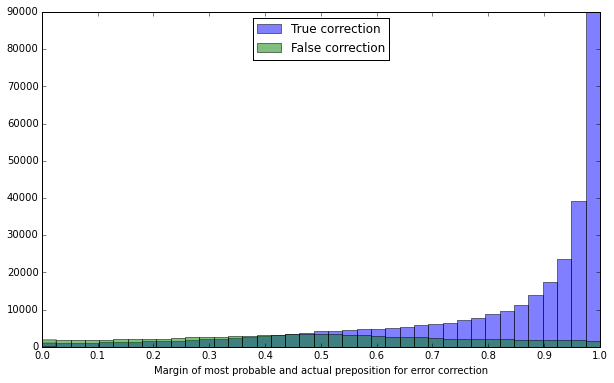

In [13]:
error_correction_correct = error_correction_preds == error_correction_targets

margin_of_most_probable_and_current_no_error = margin_of_most_probable_and_current[error_correction_correct]
margin_of_most_probable_and_current_error = margin_of_most_probable_and_current[~error_correction_correct]

plt.figure(figsize=(10,6))
bins = np.linspace(0., 1, 40)
plt.xticks(np.linspace(0, 1, 11))
plt.hist(margin_of_most_probable_and_current_no_error,
         bins, alpha=0.5, label='True correction')
plt.hist(margin_of_most_probable_and_current_error,
         bins, alpha=0.5, label='False correction')
plt.legend(loc='upper center')
plt.ylim(0, 90000)
plt.xlabel('Margin of most probable and actual preposition for error correction')

Minimizing the model's erroneous corrections will increase the system's utility in interactive applications.  The system may attempt to correct a preposition when the most probable preposition according to the model differs from the one in the sentence.  If the margin between those probabilities is sufficiently small, however, there is reason to be skeptical of the model's decision.  The above figure illustrates this.  The model makes more mistakes when the margin of probabilities is low.  Requiring that the margin be greater than a value in the range 0.0-0.3 might increase the precision of the error correction system at some cost of recall.

To this end, we've implemented a function, `predict_with_min_margin_vs_actual`, that accepts a model's prediction only if the margin between the probability of the most probable preposition and the manifest preposition exceeds some threshold.  The effect of this heuristic on precision and recall is, however, negligible, because the fraction of predictions it changes is quite small.

In [14]:
#error_correction_preds_min_margin = predict_with_min_margin_vs_actual(
#        error_correction_probs, error_correction_targets,
#        error_correction_current_word_code, min_margin=0.1)

# I'm not sure if this implementation is the same approach for evaluation used
# in some Chodrow and Tetrault papers (e.g. Chungdam corpus paper, and one by
# Chodrow and Tetrault that it cites).
error_correction_preds_absolute_threshold, abs_thresh_indices_used = predict_with_absolute_threshold(
        error_correction_probs, error_correction_targets, threshold=0.95)

In [15]:
# print('\nError correction performance without heuristic\n')
# p, r, f, s = precision_recall_fscore_support(
#         error_correction_targets, error_correction_preds)
# print(p, r, f, s)

# print('\nError correction performance with absolute threshold heuristic (threshold=0.5)\n')
# p, r, f, s = precision_recall_fscore_support(
#         error_correction_targets[abs_thresh_indices_used],
#         error_correction_preds_absolute_threshold)
# print(p, r, f, s)

# print('\nError correction performance with minimum margin heuristic\n')
# p, r, f, s = precision_recall_fscore_support(
#     error_correction_targets, error_correction_preds_min_margin)
# print(p, r, f, s)

In [16]:
margin_of_2_most_probable = np.zeros(len(indices_of_2_most_probable))
for i in np.arange(len(error_correction_preds)):
    most_probable, next_most_probable = indices_of_2_most_probable[i, :]
    margin_of_2_most_probable[i] = error_correction_probs[i, most_probable] - error_correction_probs[i, next_most_probable]

[ 0.989  0.675  0.982 ...,  0.933  0.981  0.997]
[ 0.022  0.744  0.562 ...,  0.071  0.125  0.575]


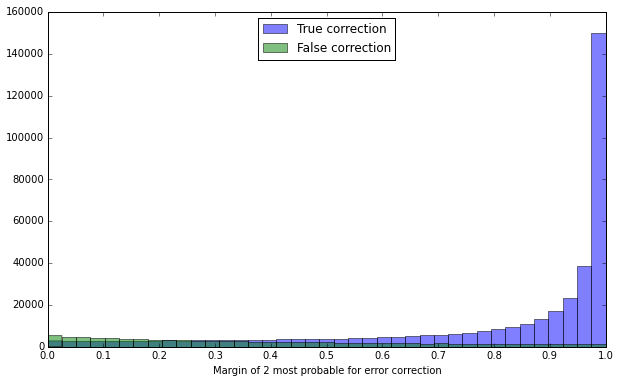

In [17]:
margin_of_2_most_probable_no_error = margin_of_2_most_probable[error_correction_correct]
margin_of_2_most_probable_error = margin_of_2_most_probable[~error_correction_correct]

print(margin_of_2_most_probable_no_error)
print(margin_of_2_most_probable_error)

bins = np.linspace(0., 1, 40)
plt.figure(figsize=(10,6))
plt.xticks(np.linspace(0, 1, 11))
plt.hist(margin_of_2_most_probable_no_error,
         bins, alpha=0.5, label='True correction')
plt.hist(margin_of_2_most_probable_error,
        bins, alpha=0.5, label='False correction')
plt.legend(loc='upper center')
plt.xlabel('Margin of 2 most probable for error correction')

Effect of length on model performance
=======

For this particular convolutional network, performance degrades with length.  I should run these reports with and without sentences that contain unknown words, in order to control for that variable.

In [18]:
print('\nError correction performance by length\n')
for i in range(0, 5):
    start = 1 + (i * 10)
    end = start + 10
    idx = np.where((error_correction_length > start) & (error_correction_length <= end))[0]
    p, r, f, s = precision_recall_fscore_support(
            error_correction_targets[idx], error_correction_preds[idx])
    print("{start:02d}-{end:02d} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
            start=start, end=end, precision=p, recall=r, f=f, support=s))


Error correction performance by length

01-11 0.83 0.83 0.83  40121
11-21 0.82 0.82 0.82 196211
21-31 0.80 0.80 0.80 160329
31-41 0.79 0.79 0.79  73878
41-51 0.78 0.78 0.78  16420


Effect of unknown words on model performance
=========

I should make sentence length a variable in this section.

In [19]:
n_unknown_words = np.zeros_like(error_correction_length)
for i in np.arange(0, len(error_correction_length)):
    n_unknown_words[i] = len(np.where(error_correction_data[i, 0:error_correction_length[i]] == 0)[0])
fraction_unknown = n_unknown_words / error_correction_length.astype(float)
idx = np.where(fraction_unknown == .0)[0]
p, r, f, s = precision_recall_fscore_support(
        error_correction_targets[idx], error_correction_preds[idx])
print("{start:.2f} <= {end:.2f} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
        start=0., end=0., precision=p, recall=r, f=f, support=s))

for i in np.linspace(0, 1, 11):
    start = i if i > 0 else 0.0001
    end = i + 0.1
    idx = np.where((fraction_unknown > start) & (fraction_unknown <= end))[0]
    if len(idx) == 0:
        continue
    p, r, f, s = precision_recall_fscore_support(
            error_correction_targets[idx], error_correction_preds[idx])
    print("{start:.2f} <= {end:.2f} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
            start=start, end=end, precision=p, recall=r, f=f, support=s))

0.00 <= 0.00 0.80 0.80 0.80 260180
0.00 <= 0.10 0.80 0.80 0.80 155627
0.10 <= 0.20 0.83 0.83 0.83  63070
0.20 <= 0.30 0.82 0.82 0.82   7091
0.30 <= 0.40 0.75 0.75 0.74    853
0.40 <= 0.50 0.80 0.75 0.74    116
0.50 <= 0.60 0.25 0.40 0.28      5
0.60 <= 0.70 0.66 0.47 0.48     17


/export/home/ndronen/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/export/home/ndronen/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Effect of number of unknown words in window around preposition
=======

In [20]:
n_unknown_words_in_window = np.zeros_like(error_correction_length)
for i in np.arange(0, len(error_correction_length)):
    n_unknown_words_in_window[i] = len(np.where(error_correction_data[i, 0:5] == 0)[0])
idx = np.where(n_unknown_words_in_window == 0)[0]
p, r, f, s = precision_recall_fscore_support(
        error_correction_targets[idx], error_correction_preds[idx])
print("{n:1d} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
        n=0, precision=p, recall=r, f=f, support=s))

for n in range(1, 6):
    idx = np.where((n_unknown_words_in_window == n))[0]
    if len(idx) == 0:
        continue
    p, r, f, s = precision_recall_fscore_support(
            error_correction_targets[idx], error_correction_preds[idx])
    print("{n:1d} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
            n=n, precision=p, recall=r, f=f, support=s))

0 0.80 0.80 0.80 362835
1 0.76 0.77 0.76  52307
2 0.87 0.87 0.87  70207
3 0.70 0.72 0.70   1590
4 0.58 0.70 0.64     20


Effect of position of unknown words in window around preposition
=======

In [21]:
window_size = 5
center = 2

assert len(np.where(error_correction_data[:, center] == 0)[0]) == 0

indices_in_window = [center-2, center-1, center+1, center+2]

results = {}

for mask in powerset(indices_in_window):
    mask = np.array(mask)
    idx = []
    for i in np.arange(len(error_correction_data)):
        zeros_in_right_places = True
        for m in mask:
            if error_correction_data[i, m] != 0:
                zeros_in_right_places = False
                break
        if zeros_in_right_places:
            idx.append(i)
    if len(idx) == 0:
        continue
    unknowns_str = ['_'] * (len(indices_in_window) + 1)
    for x in mask:
        unknowns_str[x] = "?"
    unknowns_str[center] = "P"
    unknowns_str = ' '.join(unknowns_str)
    p, r, f, s = precision_recall_fscore_support(
            error_correction_targets[idx], error_correction_preds[idx])
    results[unknowns_str] = [p, r, f, s]

for mask in sorted(results.keys(), reverse=True):
    p, r, f, s = results[mask]
    print("{unknowns}     {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
            unknowns=mask, precision=p, recall=r, f=f, support=s))

_ _ P _ _     0.81 0.81 0.80 486959
_ _ P _ ?     0.77 0.77 0.77  16545
_ _ P ? _     0.74 0.74 0.74  18086
_ _ P ? ?     0.80 0.80 0.80   1048
_ ? P _ _     0.85 0.86 0.85  75186
_ ? P _ ?     0.70 0.72 0.69   1309
_ ? P ? _     0.60 0.60 0.58    847
_ ? P ? ?     0.42 0.47 0.43     43
? _ P _ _     0.86 0.86 0.86  87754
? _ P _ ?     0.77 0.78 0.76   1776
? _ P ? _     0.71 0.71 0.70   1534
? _ P ? ?     0.79 0.73 0.72     79
? ? P _ _     0.87 0.88 0.87  68583
? ? P _ ?     0.75 0.78 0.74   1012
? ? P ? _     0.63 0.63 0.61    536
? ? P ? ?     0.58 0.70 0.64     20


Sensitivity analysis of effect of position of unknown words in window around preposition
=======
1. Take all examples in which the window around the preposition contains no unknown words.
2. For each set in the powerset of positions in the window (excluding the center, where the preposition occurs):
  1. Set the words in that position to be unknown (i.e. assign 0 to that position) for all examples.
  2. Run the examples through the model.
3. Evaluate the model's performance.

In [22]:
no_unknown_words_data = error_correction_data[n_unknown_words == 0]
no_unknown_words_targets = error_correction_targets[n_unknown_words == 0]

no_unknown_words_error_detection_targets = error_detection_targets[n_unknown_words == 0]

#error_detection_targets = np.ones_like(m20m.current_word_code)
#error_detection_targets[evens] = 0
#error_detection_preds = (preds != m20m.current_word_code).astype(int)

masks = [mask for mask in powerset(indices_in_window)]

In [23]:
detection_results = {}
correction_results = {}

for mask in masks:
    data = no_unknown_words_data.copy()[0:50000]
    mask = np.array(mask, dtype=int)
    
    data[:, mask] = 0
    
    for i in np.arange(len(data)):
        data[i, mask + error_correction_position[i] + 3] = 0

    no_unknown_words_preds = m20m.model.predict_classes(data)
    
    unknowns_str = ['_'] * (len(indices_in_window) + 1)
    for x in mask:
        unknowns_str[x] = "?"
    unknowns_str[center] = "P"
    unknowns_str = ' '.join(unknowns_str)
    
    # Error detection - this does not work yet.
#     no_unknown_words_error_detection_preds = np.zeros(shape=len(data))
#     no_unknown_words_error_detection_preds[no_unknown_words_preds != no_unknown_words_targets] = 1
    
#     detection_results[unknowns_str] = list(sklearn.metrics.precision_recall_fscore_support(
#            no_unknown_words_error_detection_targets[0:1000],
#            no_unknown_words_error_detection_preds[0:1000], average='binary'))
#     detection_results[unknowns_str][3] = len(data)
    
    # Error correction
    correction_results[unknowns_str] = precision_recall_fscore_support(
            no_unknown_words_targets[0:50000], no_unknown_words_preds)
    
# print('\nError detection sensitivity analysis\n')
# for mask in sorted(detection_results.keys(), key=lambda mask: (mask.count("?"), mask)):
#     p, r, f, s = detection_results[mask]
#     print(p, r, f, s)
#     print("{unknowns}     {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
#             unknowns=mask, precision=p, recall=r, f=f, support=s))

print('\nError correction sensitivity analysis\n')
for mask in sorted(correction_results.keys(), key=lambda mask: (mask.count("?"), mask)):
    p, r, f, s = correction_results[mask]
    print("{unknowns}     {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
            unknowns=mask, precision=p, recall=r, f=f, support=s))

50000/50000 [==============================] - 30s    

Error correction sensitivity analysis

_ _ P _ _     0.80 0.80 0.80  50000
? _ P _ _     0.75 0.75 0.75  50000
_ ? P _ _     0.62 0.60 0.60  50000
_ _ P ? _     0.65 0.62 0.62  50000
_ _ P _ ?     0.71 0.70 0.70  50000
? ? P _ _     0.55 0.52 0.52  50000
? _ P ? _     0.58 0.55 0.55  50000
? _ P _ ?     0.66 0.65 0.65  50000
_ ? P ? _     0.44 0.39 0.37  50000
_ ? P _ ?     0.51 0.48 0.48  50000
_ _ P ? ?     0.57 0.53 0.52  50000
? ? P ? _     0.38 0.32 0.31  50000
? ? P _ ?     0.46 0.42 0.43  50000
? _ P ? ?     0.52 0.47 0.46  50000
_ ? P ? ?     0.37 0.30 0.26  50000
? ? P ? ?     0.30 0.24 0.21  50000


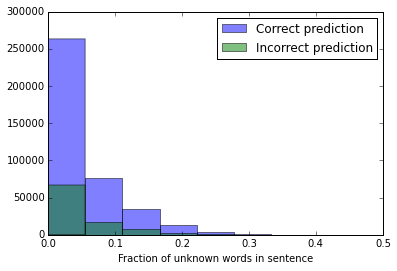

In [24]:
bins = np.linspace(0., .5, 10)
plt.hist(fraction_unknown[error_correction_targets == error_correction_preds],
         bins, alpha=0.5, label='Correct prediction')
plt.hist(fraction_unknown[error_correction_targets != error_correction_preds],
         bins, alpha=0.5, label='Incorrect prediction')
plt.legend(loc='upper right')
plt.xlabel('Fraction of unknown words in sentence')

Error detection performance conditioned on original (correct) preposition (i.e. the target variable)
========
"For" is the preposition with the lowest precision, recall, F-1, and F-0.5.

In [25]:
for code, word in enumerate(target_data['original_word_code']['names']):
    targets_with_code_idx = np.where(m20m.target == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (
        preds[targets_with_code_idx] != m20m.current_word_code[targets_with_code_idx]
    ).astype(int)

    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary')
    
    fbeta_05 = fbeta_score(
            error_detection_targets_word,
            error_detection_preds_word,
        beta=0.5)
    
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=s))

0 at    0.94 0.91 0.92 0.93  95080
1 by    0.94 0.92 0.93 0.94  95280
2 for   0.90 0.87 0.89 0.90  97520
3 from  0.90 0.89 0.89 0.89  90416
4 in    0.96 0.93 0.95 0.96 193986
5 of    0.96 0.93 0.94 0.95 111904
6 on    0.93 0.91 0.92 0.93 108802
7 to    0.96 0.95 0.96 0.96 113114
8 with  0.93 0.89 0.91 0.92  93430


Error detection performance conditioned on actual (possibly incorrect) preposition
=======
We would like to measure the difficulty of detecting an error given the actual preposition.  The prepositions with the lowest precision, recall, and F1, and F-0.5 are "for", "in", "in", and "for", respectively.

In [26]:
for code, word in enumerate(target_data['current_word_code']['names']):
    targets_with_code_idx = np.where(m20m.current_word_code == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (preds[targets_with_code_idx] != m20m.current_word_code[targets_with_code_idx]).astype(int)

    p, r, f, s = precision_recall_fscore_support(error_detection_targets_word, error_detection_preds_word, average='binary')
    fbeta_05 = fbeta_score(error_detection_targets_word, error_detection_preds_word, beta=0.5)
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=s))

0 at    0.95 0.93 0.94 0.94 104444
1 by    0.95 0.92 0.93 0.94 104430
2 for   0.92 0.89 0.90 0.91 105330
3 from  0.92 0.92 0.92 0.92 102128
4 in    0.92 0.88 0.90 0.91 147347
5 of    0.96 0.94 0.95 0.95 111355
6 on    0.94 0.92 0.93 0.93 109879
7 to    0.96 0.94 0.95 0.96 111658
8 with  0.94 0.89 0.92 0.93 102961


Error correction performance conditioned on actual (possibly incorrect) preposition and original (correct) preposition
========

In [27]:
correction_conditioned_actual_orig = []

n_error_correction = (error_detection_preds == 1).sum()

for current_word_code, current_word in enumerate(target_data['current_word_code']['names']):
    # Error correction performance is only computed over the examples for which
    # the model's predicted preposition differs from the actual preposition.
    
    # First find the examples for which the model's predicted preposition differs from
    # the actual preposition.
    error_correction_mask = error_detection_preds == 1
    
    # Then find the examples that have the given original preposition.
    targets_with_code = m20m.current_word_code == current_word_code
    
    targets_with_code_idx = np.where(error_correction_mask & targets_with_code)[0]
    error_correction_targets_word = m20m.target[targets_with_code_idx]
    error_correction_preds_word = preds[targets_with_code_idx]
    
    error_correction_targets_word = error_correction_targets_word
    error_correction_preds_word = error_correction_preds_word
    
#     print(current_word)
#     print_classification_report(
#             error_correction_targets_word,
#             error_correction_preds_word,
#             target_names=target_data['original_word_code']['names'])

    p, r, f, s = precision_recall_fscore_support(
            error_correction_targets_word,
            error_correction_preds_word,
            average=None)
    
    for original_word_code, original_word in enumerate(target_data['original_word_code']['names']):
        f1_macro = f[original_word_code] * s[original_word_code] / n_error_correction
        correction_conditioned_actual_orig.append({
                'current_word': current_word,
                'original_word': original_word,
                'precision': p[original_word_code],
                'recall': r[original_word_code],
                'f1': f[original_word_code],
                'f1macro': f1_macro,
                'n': s[original_word_code]
            })
    
#     print(p, r, f, s)
#     fbeta_05 = fbeta_score(
#             error_correction_targets_word,
#             error_correction_preds_word,
#             beta=0.5, average='weighted')
#     print("{word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
#             word=current_word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=s))
    
df = pd.DataFrame(correction_conditioned_actual_orig)
df = df.sort(['f1'])
df = df[['current_word', 'original_word', 'precision', 'recall', 'f1', 'f1macro', 'n']]
pd.set_option('display.precision', 3)

print('The 20 most difficult current-original word pairs\n')
print(df[df.precision > 0].head(n=20))
print('')

print('The 20 easiest current-original word pairs\n')
print(df[df.precision > 0].tail(n=20))
print('')

df[df.precision > 0].f1macro.sum()

The 20 most difficult current-original word pairs

   current_word original_word  precision  recall    f1   f1macro     n
29         from           for       0.74    0.75  0.75  8.46e-03  5501
65           to           for       0.75    0.75  0.75  8.36e-03  5427
56           on           for       0.74    0.76  0.75  8.14e-03  5288
47           of           for       0.75    0.76  0.75  8.13e-03  5265
2            at           for       0.76    0.76  0.76  8.77e-03  5616
38           in           for       0.75    0.78  0.76  7.92e-03  5064
11           by           for       0.76    0.76  0.76  8.43e-03  5386
74         with           for       0.75    0.78  0.77  7.55e-03  4796
35         from          with       0.73    0.81  0.77  8.40e-03  5317
62           on          with       0.73    0.81  0.77  8.19e-03  5181
71           to          with       0.74    0.81  0.77  8.51e-03  5376
53           of          with       0.74    0.80  0.77  8.64e-03  5455
26          for          w

0.78035331769475813

In [28]:
np.bincount(m20m.target)

array([ 95080,  95280,  97520,  90416, 193986, 111904, 108802, 113114,
        93430])

In [29]:
target_data['original_word_code']['names']

[u'at', u'by', u'for', u'from', u'in', u'of', u'on', u'to', u'with']

In [30]:
pd.set_option('display.max_rows', 100)
print(df[df.precision > 0])

   current_word original_word  precision  recall    f1   f1macro      n
29         from           for       0.74    0.75  0.75  8.46e-03   5501
65           to           for       0.75    0.75  0.75  8.36e-03   5427
56           on           for       0.74    0.76  0.75  8.14e-03   5288
47           of           for       0.75    0.76  0.75  8.13e-03   5265
2            at           for       0.76    0.76  0.76  8.77e-03   5616
38           in           for       0.75    0.78  0.76  7.92e-03   5064
11           by           for       0.76    0.76  0.76  8.43e-03   5386
74         with           for       0.75    0.78  0.77  7.55e-03   4796
35         from          with       0.73    0.81  0.77  8.40e-03   5317
62           on          with       0.73    0.81  0.77  8.19e-03   5181
71           to          with       0.74    0.81  0.77  8.51e-03   5376
53           of          with       0.74    0.80  0.77  8.64e-03   5455
26          for          with       0.72    0.84  0.77  7.68e-03

Correlation of number of examples and performance
===========
The distribution of errors in the validation set is proportional to that of the training set.  The figures and tables below explore the relationship between the number of training examples and the performance on each kind of example.

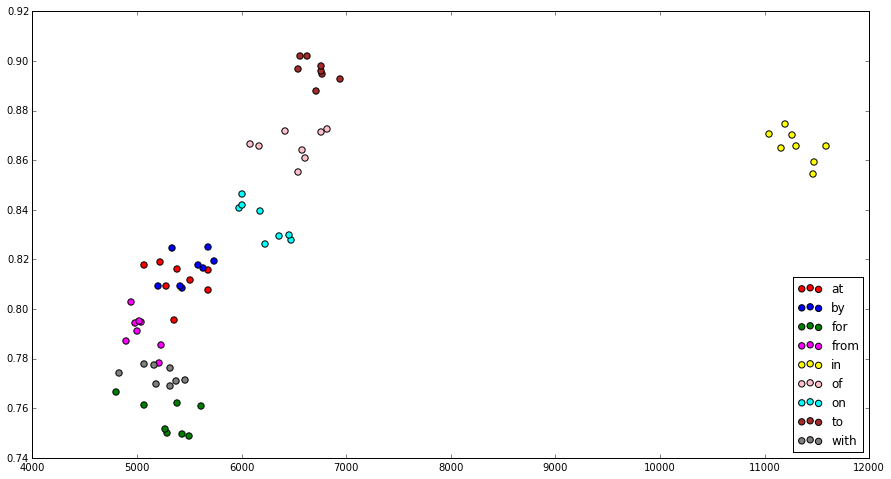

In [31]:
plt.figure(figsize=(15,8))
cols = ['red', 'blue', 'green', 'magenta', 'yellow', 'pink', 'cyan', 'brown', 'gray', 'black']
for i, original_word in enumerate(target_data['original_word_code']['names']):
    df_original_word = df[(df.f1 > 0) & (df.original_word == original_word)]
    plt.scatter(df_original_word.n, df_original_word.f1, c=cols[i], label=original_word, s=40)
plt.legend(loc='lower right')

In [32]:
df_without_in = df[df.original_word != 'in']

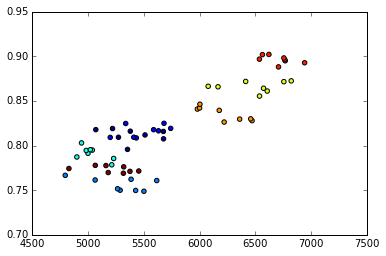

In [33]:
cols = [target_data['original_word_code']['names'].index(w) for w in df_without_in[df_without_in.f1 > 0].original_word]
plt.scatter(df_without_in[df_without_in.f1 > 0].n, df_without_in[df_without_in.f1 > 0].f1, c=cols)

In [34]:
np.corrcoef(df_without_in[df_without_in.f1 > 0].n, df_without_in[df_without_in.f1 > 0].f1)

array([[ 1.   ,  0.856],
       [ 0.856,  1.   ]])

Sizes of things
========

In [35]:
train_size = 59972006
validation_size = 999532
test_size = 999552

In [36]:
for original_word_code, original_word in enumerate(target_data['original_word_code']['names']):
    n = (m20m.target == original_word_code).sum()
    print("{word:20s} {n:7d}".format(word=original_word, n=n))

at                     95080
by                     95280
for                    97520
from                   90416
in                    193986
of                    111904
on                    108802
to                    113114
with                   93430


In [37]:
google_n_gram_pcts = np.array([.3015, .4219, .6588, .3345, 1.559, 2.939, .4719, 1.976, .516])
normalized_google_n_gram_pcts = google_n_gram_pcts / google_n_gram_pcts.sum()
print(normalized_google_n_gram_pcts)

[ 0.033  0.046  0.072  0.036  0.17   0.32   0.051  0.215  0.056]
